# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 11 </span>
## <span style="color:orange"> Keras - Neural Network regression </span>

### Overview 

In this notebook our task will be to perform machine learning regression on noisy data with a Neural Network (NN).

We will explore how the ability to fit depends on the structure of the NN. The goal is also to build intuition about why prediction is difficult.

### The Prediction Problem

Consider a probabilistic process that gives rise to labeled data $(x,y)$. The data is generated by drawing samples from the equation

$$
    y_i= f(x_i) + \eta_i,
$$

where $f(x_i)$ is some fixed, but (possibly unknown) function, and $\eta_i$ is a Gaussian, uncorrelate noise variable such that

$$
\langle \eta_i \rangle=0 \\
\langle \eta_i \eta_j \rangle = \delta_{ij} \sigma
$$

We will refer to the $f(x_i)$ as the **true features** used to generate the data. 

To make predictions, we will consider a NN that depends on its parameters, weights and biases. The functions that the NN can model respresent the **model class** that we are using to try to model the data and make predictions.

To learn the parameters of the NN, we will train our models on a **training data set** and then test the effectiveness of the NN on a *different* dataset, the **validation data set**. The reason we must divide our data into a training and test dataset is that the point of machine learning is to make accurate predictions about new data we have not seen.

To measure our ability to predict, we will learn our parameters by fitting our training dataset and then making predictions on our test data set. One common measure of predictive  performance of our algorithm is to compare the predictions,$\{y_j^\mathrm{pred}\}$, to the true values $\{y_j\}$. A commonly employed measure for this is the sum of the mean square-error (MSE) on the test set:
$$
MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$$

We will try to get a qualitative picture by examining plots on validation and training data.

## <span style="color:blue"> Svolgimento </span>

### Funzionamento di una rete neurale

L'idea alla base delle reti neurali e, più in generale, del machine learning, è quella di non fornire alla macchina un algoritmo predefinito per risolvere un problema, ma di addestrare la macchina mostrandole molti dati di input con i corrispondenti dati di output, in modo che la macchina stessa possa creare il miglior "algoritmo" per predire i dati di output futuri.

Una rete neurale è costituita da unità elementari chiamate neuroni.

Un neurone prende ciascun dato di input $x_i$, gli attribuisce un peso $w_i$, e poi aggiunge al risultato un parametro $b$ chiamato bias.
Pertanto, il singolo neurone è caratterizzato da due parametri: il vettore dei pesi e il bias.

Per il funzionamento della rete è fondamentale scegliere un'opportuna funzione di attivazione $f(z)$, dove $z=x \cdot w +b $.
Il valore predetto con la funzione di attivazione viene poi confrontato con l'output del test della rete attraverso una funzione di costo (solitamente MSE nei problemi di fitting).

Infine, la rete troverà i migliori parametri che minimizzano la funzione di costo.

### Training

La rete necessita' pertanto di molte coppie di dati di input e di output (x,y) per essere allenata: questi dati vengono di solito divisi in dati di train, con cui la rete verra' allenata, e in dati di test, con la quale si verificheranno le prestaioni della rete e la sua capacita' di lavorare con dati nuovi.

### Suddivisione in epoche ed overfitting

I dati sono divisi in blocchi detti "epoche", all' interno di ogni epoca vengono utilizzati metodi a gradiente decrescente (noi useremo il SGD) per cercare di minimizzare le funzioni di costo e trovare i parametri della rete migliore.

Un problema in cui e' possibile incorrere e' quello dell'overfitting: quando si usando epoche molto lunghe, la rete potrebbe basarsi troppo sui dati di train e non essere quindi in grado di adattarsi a dati nuovi e diversi da quelli con cui e' stata allenata. Per evitare questo problema in questa esercitazione si e' deciso di mescolare i dati all'inizio di ogni epoca (shuffle).

Di seguito vengono illustrati gli esiti di diversi test della rete, effettuati modificando leggermente alcuni parametri come: il numero di dati di training, il numero di epoche e l'errore $\sigma$. 


### Linear fit

We start by considering the very simple case:
$$
f(x)=2x+1
$$

Let's start defining the parameters of an ideal linear function which we are going to predict through a neural network regression

In [9]:
# target parameters of f(x) = m*x + b
m = 2 # slope
b = 1 # intersect

Now let's generate a set of input data which will slightly deviate from our ideal behaviour using a random noise (that actually is set to zero):

In [22]:
import numpy as np

# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 1000)
x_valid = np.random.uniform(-1, 1, 100)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.2 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)

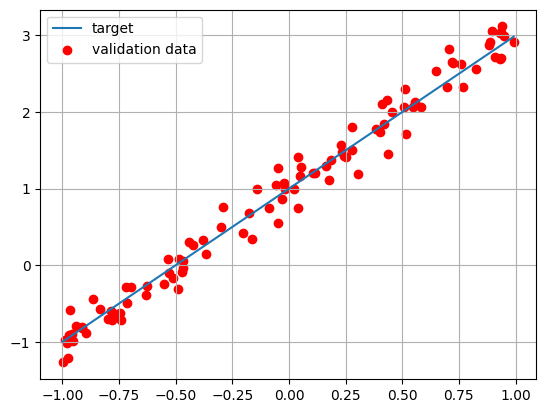

In [23]:
# plot validation and target dataset
import matplotlib.pyplot as plt
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.legend()
plt.grid(True)
plt.show()

If you remember how a single node of a neural network works, you can easily spot that **just a single neuron can make the job**. So let's start using a simple Sequential model with just one layer on one neuron only!

In [35]:
# compose the NN model
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))     #un neurone con un parametro, peso w e bias b dato x---> xw+b

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

In [36]:
# get a summary of our composed model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We are now going to train our model, that is we feed the neuron with the set of training pair x, y_train from which the optimizer will find the best weights to minimize the Mean Square Error loss function (out linear regression function).

In [37]:
# fit the model using training dataset
# over 10 epochs of 32 batch size each
# report training progress against validation data
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=30,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/30
32/32 [==============================] - 1s 6ms/step - loss: 0.6720 - mse: 0.6720 - val_loss: 0.3589 - val_mse: 0.3589
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2323 - mse: 0.2323 - val_loss: 0.1486 - val_mse: 0.1486
Epoch 3/30
32/32 [==============================] - 0s 3ms/step - loss: 0.1063 - mse: 0.1063 - val_loss: 0.0822 - val_mse: 0.0822
Epoch 4/30
32/32 [==============================] - 0s 7ms/step - loss: 0.0659 - mse: 0.0659 - val_loss: 0.0588 - val_mse: 0.0588
Epoch 5/30
32/32 [==============================] - 0s 4ms/step - loss: 0.0516 - mse: 0.0516 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 6/30
32/32 [==============================] - 0s 3ms/step - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0432 - val_mse: 0.0432
Epoch 7/30
32/32 [==============================] - 0s 3ms/step - loss: 0.0425 - mse: 0.0425 - val_loss: 0.0401 - val_mse: 0.0401
Epoch 8/30
32/32 [==============================] - 0s 3ms/step - loss: 0.0408 - mse: 0.04

By looking at weights and biases we can see if the linear fit was successfull: $w_1$ represents the angular coefficient, $b$ the intercept.

In [38]:
# return weights and biases
model.get_weights()

[array([[2.002499]], dtype=float32), array([1.0031632], dtype=float32)]

In [39]:
# evaluate model
score = model.evaluate(x_valid, y_valid, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4/4 [==============================] - 0s 3ms/step - loss: 0.0328 - mse: 0.0328

Test loss: 0.03280431404709816
Test accuracy: 0.03280431404709816


In [40]:
# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4/4 [==============================] - 0s 6ms/step - loss: 1.1811e-05 - mse: 1.1811e-05

Test loss: 1.1811142030637711e-05
Test accuracy: 1.1811142030637711e-05


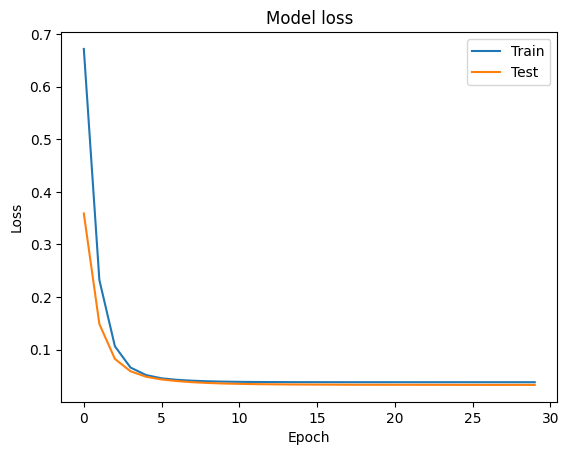

In [41]:
# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

4/4 [==============================] - 0s 2ms/step


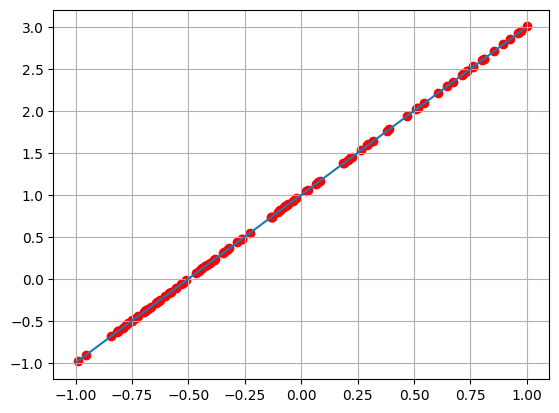

In [42]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

### Exercise 11.1

In order to make practice with NN, explore how does the previous linear regression depend on the number of epochs, $N_{\mathrm{epochs}}$, the number of data points $N_{\mathrm{train}}$ and on the noise $\sigma$. Try to improve the previous result operating on these parameters.

In [43]:
# target parameters of f(x) = m*x + b
m = 2 # slope
b = 1 # intersect

import numpy as np


# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 500)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.9 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)


#inizializzo la rete

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects


model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

In [44]:
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=30,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 1s 14ms/step - loss: 1.7549 - mse: 1.7549 - val_loss: 2.0438 - val_mse: 2.0438
Epoch 2/30
16/16 [==============================] - 0s 7ms/step - loss: 1.3985 - mse: 1.3985 - val_loss: 1.6682 - val_mse: 1.6682
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 1.1941 - mse: 1.1941 - val_loss: 1.4238 - val_mse: 1.4238
Epoch 4/30
16/16 [==============================] - 0s 10ms/step - loss: 1.0691 - mse: 1.0691 - val_loss: 1.2662 - val_mse: 1.2662
Epoch 5/30
16/16 [==============================] - 0s 9ms/step - loss: 0.9901 - mse: 0.9901 - val_loss: 1.1586 - val_mse: 1.1586
Epoch 6/30
16/16 [==============================] - 0s 6ms/step - loss: 0.9391 - mse: 0.9391 - val_loss: 1.0910 - val_mse: 1.0910
Epoch 7/30
16/16 [==============================] - 0s 11ms/step - loss: 0.9043 - mse: 0.9043 - val_loss: 1.0357 - val_mse: 1.0357
Epoch 8/30
16/16 [==============================] - 0s 11ms/step - loss: 0.8785 - mse:

2/2 [==============================] - 0s 10ms/step - loss: 0.0106 - mse: 0.0106

Test loss: 0.010577123612165451
Test accuracy: 0.010577123612165451
sigma: 0.9
N_train: 500
[array([[2.0552702]], dtype=float32), array([0.90485746], dtype=float32)]


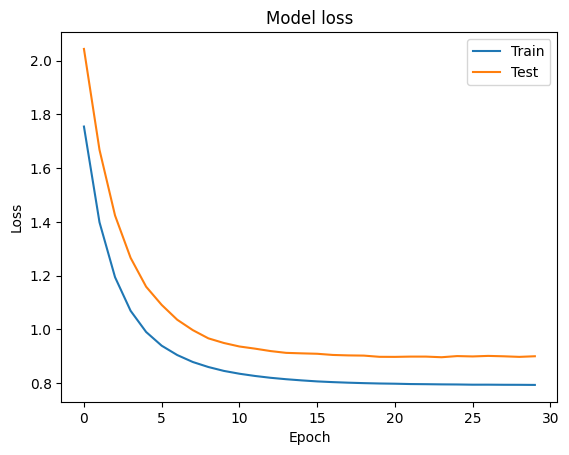

4/4 [==============================] - 0s 3ms/step


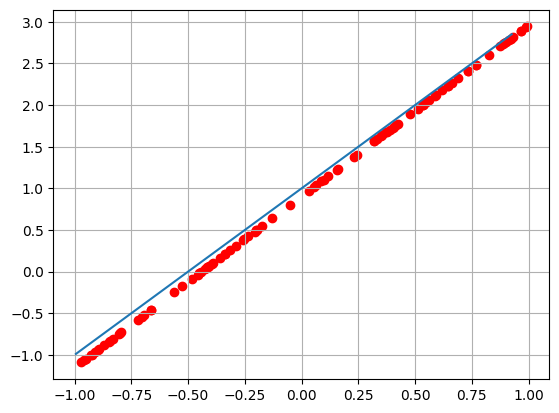

In [45]:
# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)


import matplotlib.pyplot as plt
# print performance
print()
print('Test loss:', score[0]) #la funzione costo ovvero mse
print('Test accuracy:', score[1]) #
print("sigma:", sigma)
print("N_train:", x_train.size)

print(model.get_weights())


# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

In [46]:
model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])


history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=150,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/150
16/16 [==============================] - 1s 17ms/step - loss: 2.8187 - mse: 2.8187 - val_loss: 2.7935 - val_mse: 2.7935
Epoch 2/150
16/16 [==============================] - 0s 9ms/step - loss: 2.2568 - mse: 2.2568 - val_loss: 2.2728 - val_mse: 2.2728
Epoch 3/150
16/16 [==============================] - 0s 7ms/step - loss: 1.8838 - mse: 1.8838 - val_loss: 1.9154 - val_mse: 1.9154
Epoch 4/150
16/16 [==============================] - 0s 6ms/step - loss: 1.6260 - mse: 1.6260 - val_loss: 1.6658 - val_mse: 1.6658
Epoch 5/150
16/16 [==============================] - 0s 5ms/step - loss: 1.4418 - mse: 1.4418 - val_loss: 1.4817 - val_mse: 1.4817
Epoch 6/150
16/16 [==============================] - 0s 9ms/step - loss: 1.3031 - mse: 1.3031 - val_loss: 1.3449 - val_mse: 1.3449
Epoch 7/150
16/16 [==============================] - 0s 5ms/step - loss: 1.1976 - mse: 1.1976 - val_loss: 1.2436 - val_mse: 1.2436
Epoch 8/150
16/16 [==============================] - 0s 10ms/step - loss: 1.1149 -

2/2 [==============================] - 0s 6ms/step - loss: 0.0138 - mse: 0.0138

Test loss: 0.013839729130268097
Test accuracy: 0.013839729130268097
sigma: 0.9
N_train: 500
[array([[2.098978]], dtype=float32), array([0.90154016], dtype=float32)]


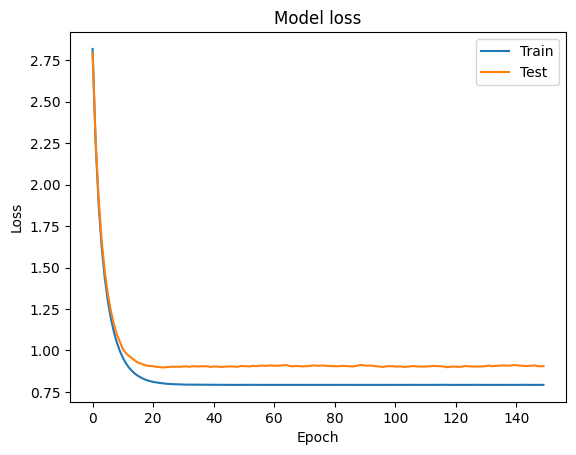

4/4 [==============================] - 0s 3ms/step


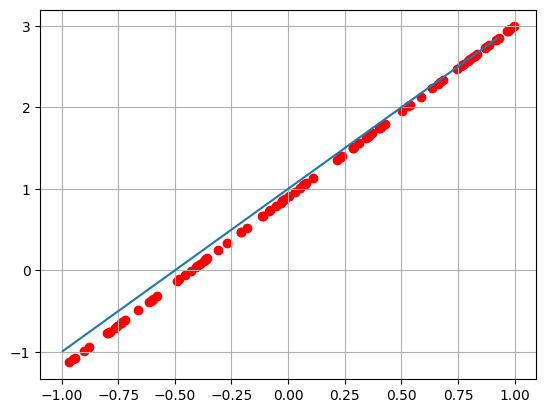

In [47]:
# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)


import matplotlib.pyplot as plt
# print performance
print()
print('Test loss:', score[0]) #la funzione costo ovvero mse
print('Test accuracy:', score[1]) #
print("sigma:", sigma)
print("N_train:", x_train.size)


print(model.get_weights())


# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

In [48]:
# target parameters of f(x) = m*x + b
m = 2 # slope
b = 1 # intersect

import numpy as np


# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 1000)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.9 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)


#inizializzo la rete

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,))) #un neurone con un parametro, peso w e bias b dato x---> xw+b

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])


history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=30,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/30
32/32 [==============================] - 1s 9ms/step - loss: 3.7044 - mse: 3.7044 - val_loss: 3.1583 - val_mse: 3.1583
Epoch 2/30
32/32 [==============================] - 0s 4ms/step - loss: 2.4499 - mse: 2.4499 - val_loss: 2.2931 - val_mse: 2.2931
Epoch 3/30
32/32 [==============================] - 0s 6ms/step - loss: 1.7986 - mse: 1.7986 - val_loss: 1.7776 - val_mse: 1.7776
Epoch 4/30
32/32 [==============================] - 0s 5ms/step - loss: 1.4194 - mse: 1.4194 - val_loss: 1.4418 - val_mse: 1.4418
Epoch 5/30
32/32 [==============================] - 0s 4ms/step - loss: 1.1847 - mse: 1.1847 - val_loss: 1.2142 - val_mse: 1.2142
Epoch 6/30
32/32 [==============================] - 0s 6ms/step - loss: 1.0362 - mse: 1.0362 - val_loss: 1.0572 - val_mse: 1.0572
Epoch 7/30
32/32 [==============================] - 0s 5ms/step - loss: 0.9387 - mse: 0.9387 - val_loss: 0.9568 - val_mse: 0.9568
Epoch 8/30
32/32 [==============================] - 0s 5ms/step - loss: 0.8792 - mse: 0.87

2/2 [==============================] - 0s 7ms/step - loss: 0.0017 - mse: 0.0017

Test loss: 0.0016574342735111713
Test accuracy: 0.0016574342735111713
sigma: 0.9
N_train: 1000
[array([[1.9543246]], dtype=float32), array([1.0286899], dtype=float32)]


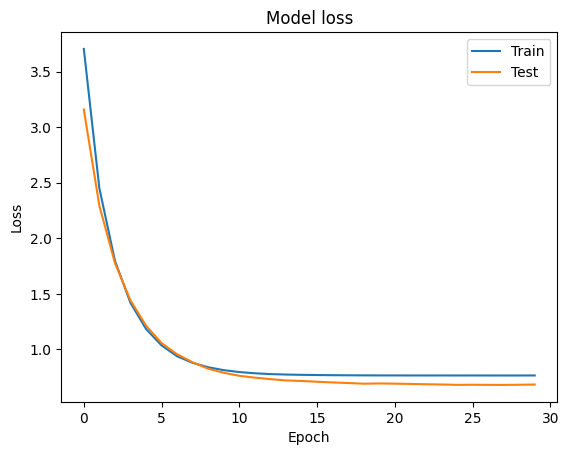

4/4 [==============================] - 0s 4ms/step


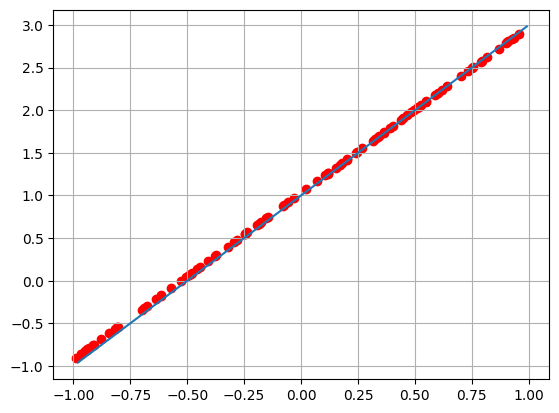

In [49]:
# evaluate model with the exact curve
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)


import matplotlib.pyplot as plt
# print performance
print()
print('Test loss:', score[0]) #la funzione costo ovvero mse
print('Test accuracy:', score[1]) #
print("sigma:", sigma)
print("N_train:", x_train.size)


print(model.get_weights())


# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

### Exercise 11.2

Try to extend the model to obtain a reasonable fit of the following polynomial of order 3:

$$
f(x)=4-3x-2x^2+3x^3
$$
for $x \in [-1,1]$.

Find good (& reasonable) choices for:

- the number of layers
- the number of neurons in each layer
- the activation function
- the optimizer
- the loss function
  
Check your NN model by seeing how well your fits predict newly generated test data (including on data outside the range you fit. How well do your NN do on points in the range of $x$ where you trained the model? How about points outside the original training data set? 
Summarize what you have learned about the relationship between model complexity (number of parameters), goodness of fit on training data, and the ability to predict well.

### Exercise 11.3
  
Try to extend the model to fit a simple trigonometric 2D function such as $f(x,y) = \sin(x^2+y^2)$ in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

Ideas to meditate on these exercises and judge your results can be found <a href=https://xkcd.com/2048/>here</a>

## <span style="color:blue"> Svolgimento esercizio 11.2 </span>

Si sono effettuate diverse prove per cercare di trovare la rete migliore per fittare il polinomio: 
$$
f(x)=4-3x-2x^2+3x^3
$$
in $x \in [-1,1]$. In ogni prova si sono utilizzati 4000 dati di train e 400 dati di test, con un rumore $\sigma=0.5$ e utilizzando 80 epoche. Tutti i neuroni utilizzati sono fully connected (densi), utilizzano il sgd come ottimizzatore e la MSE come funzione di costo e metrica.

1. La prima rete proposta utilizza un layer da 10 neuroni densi con una funzione di attivazione di tipo relu. Essa genera un fit soddisfacente, eccetto per le zone di curvatura della funzione. 

2. La seconda rete utilizza anch'essa un layer da 10 neuroni, questa volta scegliendo come funzione di attivazione la sigmoide. I risultati di tale rete sono molto peggiori rispetto al precedente, si procederà dunque nell'utilizzare la funzione relu.

3. La terza rete aggiunge un ulteriore layer di 5 neuroni densi con funzione relu alla prima rete. L'esito è decisamente migliore rispetto al primo caso ma ancora non si ha un buon fitting nelle zone di massima curvatura

4. Si è deciso nuovamente di aggiungere un altro strato di 5 neuroni relu, generando un ottimo risultato per il fitting del polinomio voluto e nell'intervallo richiesto. Questa soluzione è senza alcun dubbio la migliore tra quelle proposte

5. Infine, si è voluto dimostrare che l'aumento della complessità della rete (aumento del numero di parametri) non si traduce automaticamente in una migliore performance nella soluzione del problema. L'ultima rete è infatti composta da 6 layers contenenti 250 neuroni l'uno e che utilizzano diverse funzioni di attivazione (relu, tanh e sigmoide). Come è possibile osservare, la funzione di costo ha un andamento leggermente oscillante e il risultato del fit è di gran lunga peggiore rispetto al caso precedente.

Una volta selezionata la rete neurale migliore tra quelle proposte, si è provato a generare il fit del polinomio in un intervallo più ampio. Come da aspettative, la soluzione proposta dalla rete è del tutto sbagliata e questo è dovuto al fatto che essa non è stata allenata al di fuori dell'intervallo iniziale


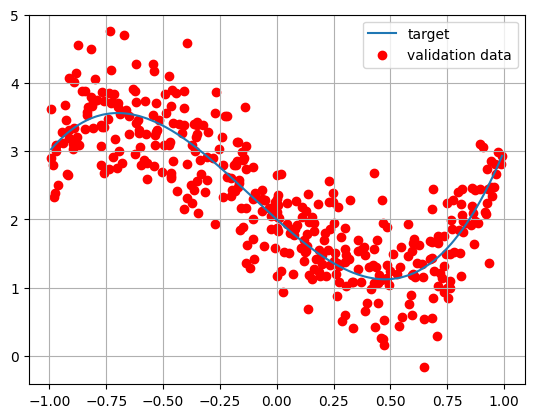

In [3]:
# target parameters of f(x) = a + bx + cxx+ dxxx
a=4
b=-3
c=-2
d=3

import numpy as np

def function(a,b,c,d,x):
    return a+b*x+c+x*x+d*x*x*x

# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 4000)
x_valid = np.random.uniform(-1, 1, 400)
x_valid.sort()
y_target = function(a,b,c,d,x_valid) # ideal (target) linear function

sigma = 0.5 # noise standard deviation
y_train = np.random.normal(function(a,b,c,d,x_train), sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(function(a,b,c,d,x_valid), sigma)
 # plot validation and target dataset
import matplotlib.pyplot as plt
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
#inizializzo la rete

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(10, input_shape=(1,),activation="relu")) 
model.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# get a summary of our composed model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                20        
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=80,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/80
125/125 [==============================] - 1s 5ms/step - loss: 1.2436 - mse: 1.2436 - val_loss: 0.4090 - val_mse: 0.4090
Epoch 2/80
125/125 [==============================] - 0s 3ms/step - loss: 0.4181 - mse: 0.4181 - val_loss: 0.3502 - val_mse: 0.3502
Epoch 3/80
125/125 [==============================] - 1s 5ms/step - loss: 0.3867 - mse: 0.3867 - val_loss: 0.3375 - val_mse: 0.3375
Epoch 4/80
125/125 [==============================] - 0s 3ms/step - loss: 0.3764 - mse: 0.3764 - val_loss: 0.3321 - val_mse: 0.3321
Epoch 5/80
125/125 [==============================] - 0s 3ms/step - loss: 0.3701 - mse: 0.3701 - val_loss: 0.3283 - val_mse: 0.3283
Epoch 6/80
125/125 [==============================] - 0s 3ms/step - loss: 0.3644 - mse: 0.3644 - val_loss: 0.3230 - val_mse: 0.3230
Epoch 7/80
125/125 [==============================] - 0s 3ms/step - loss: 0.3589 - mse: 0.3589 - val_loss: 0.3211 - val_mse: 0.3211
Epoch 8/80
125/125 [==============================] - 0s 3ms/step - loss: 0.

13/13 [==============================] - 0s 2ms/step - loss: 0.0075 - mse: 0.0075

Test loss: 0.00747699337080121
Test accuracy: 0.00747699337080121
sigma: 0.5
N_train: 4000


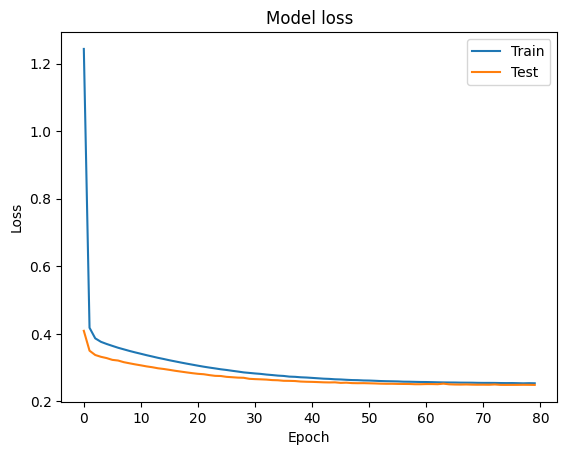

4/4 [==============================] - 0s 2ms/step


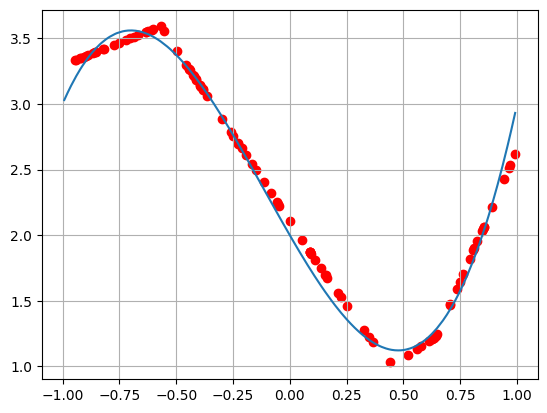

In [6]:
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)


import matplotlib.pyplot as plt
# print performance
print()
print('Test loss:', score[0]) #la funzione costo ovvero mse
print('Test accuracy:', score[1]) #
print("sigma:", sigma)
print("N_train:", x_train.size)



# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

In [7]:
#inizializzo la rete

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(10, input_shape=(1,),activation="sigmoid"))
model.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# get a summary of our composed model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                20        
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=80,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/80
125/125 [==============================] - 1s 6ms/step - loss: 1.0570 - mse: 1.0570 - val_loss: 0.6920 - val_mse: 0.6920
Epoch 2/80
125/125 [==============================] - 1s 6ms/step - loss: 0.6885 - mse: 0.6885 - val_loss: 0.5939 - val_mse: 0.5939
Epoch 3/80
125/125 [==============================] - 3s 23ms/step - loss: 0.6102 - mse: 0.6102 - val_loss: 0.5306 - val_mse: 0.5306
Epoch 4/80
125/125 [==============================] - 0s 2ms/step - loss: 0.5660 - mse: 0.5660 - val_loss: 0.4975 - val_mse: 0.4975
Epoch 5/80
125/125 [==============================] - 1s 5ms/step - loss: 0.5432 - mse: 0.5432 - val_loss: 0.4805 - val_mse: 0.4805
Epoch 6/80
125/125 [==============================] - 0s 2ms/step - loss: 0.5320 - mse: 0.5320 - val_loss: 0.4699 - val_mse: 0.4699
Epoch 7/80
125/125 [==============================] - 0s 4ms/step - loss: 0.5263 - mse: 0.5263 - val_loss: 0.4635 - val_mse: 0.4635
Epoch 8/80
125/125 [==============================] - 0s 2ms/step - loss: 0

13/13 [==============================] - 0s 3ms/step - loss: 0.1299 - mse: 0.1299

Test loss: 0.12992142140865326
Test accuracy: 0.12992142140865326
sigma: 0.5
N_train: 4000


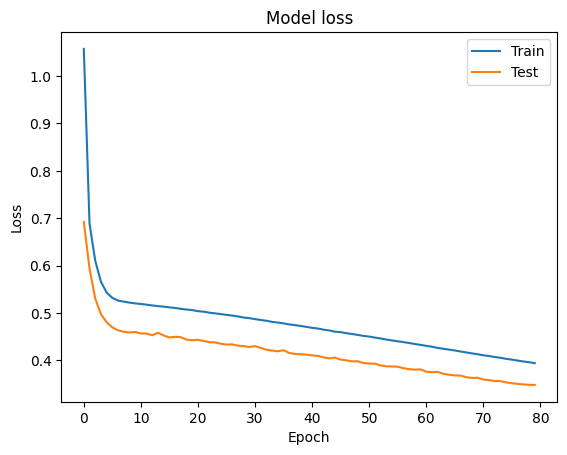

4/4 [==============================] - 0s 2ms/step


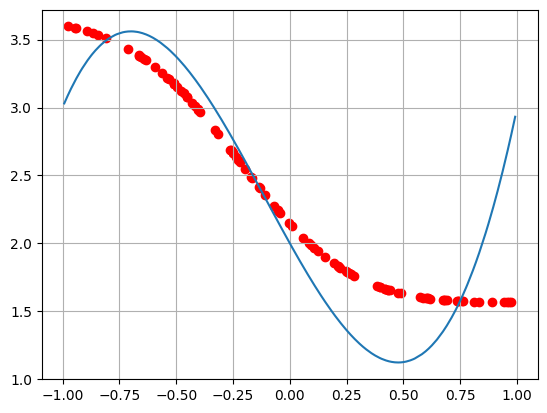

In [9]:
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)


import matplotlib.pyplot as plt
# print performance
print()
print('Test loss:', score[0]) #la funzione costo ovvero mse
print('Test accuracy:', score[1]) #
print("sigma:", sigma)
print("N_train:", x_train.size)



# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

In [10]:
#inizializzo la rete

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(10, input_shape=(1,),activation="relu"))
model.add(Dense(5, input_shape=(1,),activation="relu"))
model.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# get a summary of our composed model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                20        
                                                                 
 dense_7 (Dense)             (None, 5)                 55        
                                                                 
 dense_8 (Dense)             (None, 1)                 6         
                                                                 
Total params: 81 (324.00 Byte)
Trainable params: 81 (324.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=80,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/80
125/125 [==============================] - 1s 4ms/step - loss: 0.9160 - mse: 0.9160 - val_loss: 0.3297 - val_mse: 0.3297
Epoch 2/80
125/125 [==============================] - 0s 2ms/step - loss: 0.3636 - mse: 0.3636 - val_loss: 0.3192 - val_mse: 0.3192
Epoch 3/80
125/125 [==============================] - 0s 2ms/step - loss: 0.3496 - mse: 0.3496 - val_loss: 0.3116 - val_mse: 0.3116
Epoch 4/80
125/125 [==============================] - 0s 3ms/step - loss: 0.3413 - mse: 0.3413 - val_loss: 0.3065 - val_mse: 0.3065
Epoch 5/80
125/125 [==============================] - 0s 3ms/step - loss: 0.3343 - mse: 0.3343 - val_loss: 0.3017 - val_mse: 0.3017
Epoch 6/80
125/125 [==============================] - 0s 3ms/step - loss: 0.3270 - mse: 0.3270 - val_loss: 0.2977 - val_mse: 0.2977
Epoch 7/80
125/125 [==============================] - 0s 2ms/step - loss: 0.3204 - mse: 0.3204 - val_loss: 0.2909 - val_mse: 0.2909
Epoch 8/80
125/125 [==============================] - 1s 4ms/step - loss: 0.

13/13 [==============================] - 0s 2ms/step - loss: 0.0048 - mse: 0.0048

Test loss: 0.004783313721418381
Test accuracy: 0.004783313721418381
sigma: 0.5
N_train: 4000


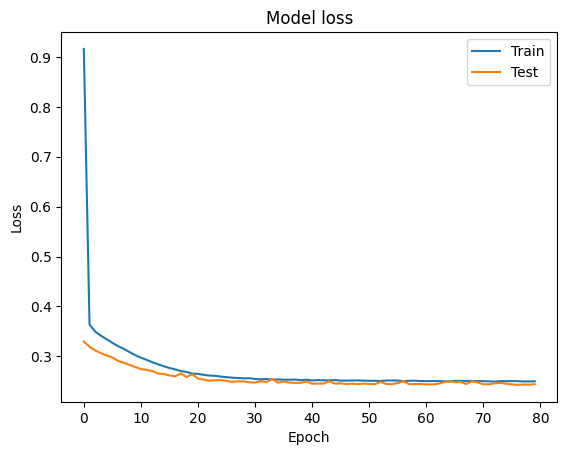

4/4 [==============================] - 0s 3ms/step


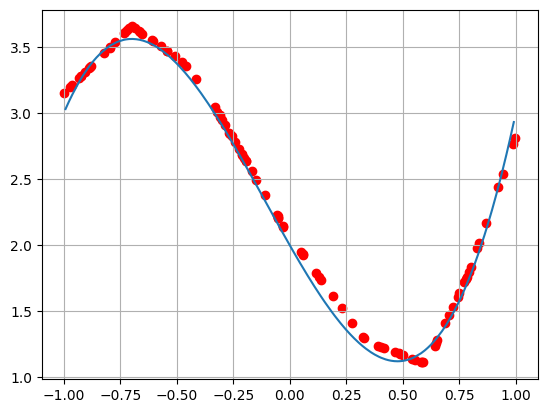

In [12]:
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)


import matplotlib.pyplot as plt
# print performance
print()
print('Test loss:', score[0]) #la funzione costo ovvero mse
print('Test accuracy:', score[1]) #
print("sigma:", sigma)
print("N_train:", x_train.size)



# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

In [36]:
#inizializzo la rete

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(10, input_shape=(1,),activation="relu"))
model.add(Dense(5, input_shape=(1,),activation="relu"))
model.add(Dense(5, input_shape=(1,),activation="relu"))
model.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# get a summary of our composed model
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 10)                20        
                                                                 
 dense_52 (Dense)            (None, 5)                 55        
                                                                 
 dense_53 (Dense)            (None, 5)                 30        
                                                                 
 dense_54 (Dense)            (None, 1)                 6         
                                                                 
Total params: 111 (444.00 Byte)
Trainable params: 111 (444.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=80,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/80
125/125 [==============================] - 1s 5ms/step - loss: 1.2178 - mse: 1.2178 - val_loss: 0.3857 - val_mse: 0.3857
Epoch 2/80
125/125 [==============================] - 0s 4ms/step - loss: 0.3843 - mse: 0.3843 - val_loss: 0.3269 - val_mse: 0.3269
Epoch 3/80
125/125 [==============================] - 0s 3ms/step - loss: 0.3624 - mse: 0.3624 - val_loss: 0.3188 - val_mse: 0.3188
Epoch 4/80
125/125 [==============================] - 0s 3ms/step - loss: 0.3528 - mse: 0.3528 - val_loss: 0.3125 - val_mse: 0.3125
Epoch 5/80
125/125 [==============================] - 0s 2ms/step - loss: 0.3436 - mse: 0.3436 - val_loss: 0.3084 - val_mse: 0.3084
Epoch 6/80
125/125 [==============================] - 0s 4ms/step - loss: 0.3352 - mse: 0.3352 - val_loss: 0.3004 - val_mse: 0.3004
Epoch 7/80
125/125 [==============================] - 1s 6ms/step - loss: 0.3262 - mse: 0.3262 - val_loss: 0.2964 - val_mse: 0.2964
Epoch 8/80
125/125 [==============================] - 0s 3ms/step - loss: 0.

2/2 [==============================] - 0s 8ms/step - loss: 1.2471 - mse: 1.2471

Test loss: 1.2470625638961792
Test accuracy: 1.2470625638961792
sigma: 0.5
N_train: 4000


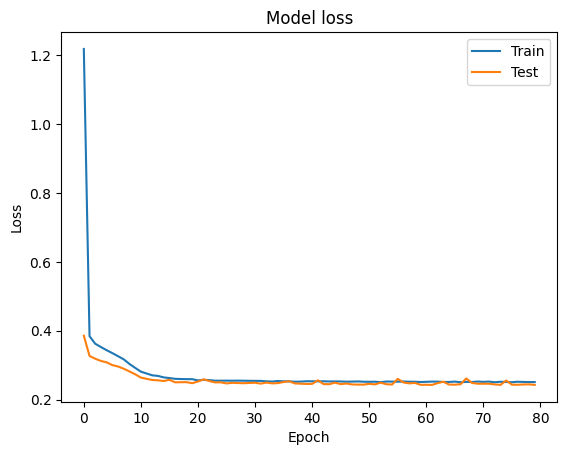

4/4 [==============================] - 0s 2ms/step


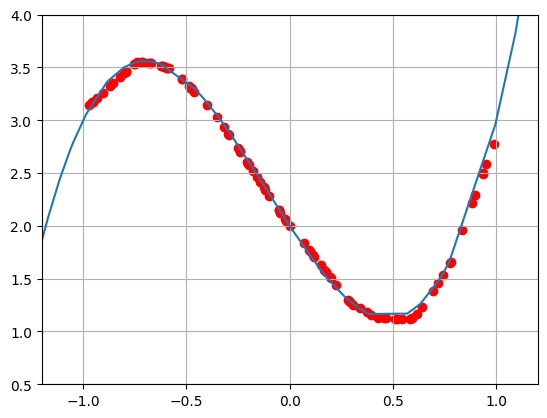

In [46]:
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)


import matplotlib.pyplot as plt
# print performance
print()
print('Test loss:', score[0]) #la funzione costo ovvero mse
print('Test accuracy:', score[1]) #
print("sigma:", sigma)
print("N_train:", x_train.size)



# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.xlim(-1.2, 1.2)
plt.ylim(0.5, 4)
plt.grid(True)
plt.show()

In [23]:
#inizializzo la rete

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(250, input_shape=(1,),activation="relu"))
model.add(Dense(250, input_shape=(1,),activation="relu"))
model.add(Dense(250, input_shape=(1,),activation="tanh"))
model.add(Dense(250, input_shape=(1,),activation="elu"))
model.add(Dense(250, input_shape=(1,),activation="sigmoid"))
model.add(Dense(250, input_shape=(1,),activation="relu"))
model.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# get a summary of our composed model
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 250)               500       
                                                                 
 dense_32 (Dense)            (None, 250)               62750     
                                                                 
 dense_33 (Dense)            (None, 250)               62750     
                                                                 
 dense_34 (Dense)            (None, 250)               62750     
                                                                 
 dense_35 (Dense)            (None, 250)               62750     
                                                                 
 dense_36 (Dense)            (None, 250)               62750     
                                                                 
 dense_37 (Dense)            (None, 1)                

In [24]:
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=80,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))

Epoch 1/80
125/125 [==============================] - 2s 9ms/step - loss: 1.1177 - mse: 1.1177 - val_loss: 0.8881 - val_mse: 0.8881
Epoch 2/80
125/125 [==============================] - 1s 5ms/step - loss: 0.8575 - mse: 0.8575 - val_loss: 0.5550 - val_mse: 0.5550
Epoch 3/80
125/125 [==============================] - 1s 5ms/step - loss: 0.5124 - mse: 0.5124 - val_loss: 0.3981 - val_mse: 0.3981
Epoch 4/80
125/125 [==============================] - 1s 5ms/step - loss: 0.4273 - mse: 0.4273 - val_loss: 0.3523 - val_mse: 0.3523
Epoch 5/80
125/125 [==============================] - 1s 5ms/step - loss: 0.4087 - mse: 0.4087 - val_loss: 0.3524 - val_mse: 0.3524
Epoch 6/80
125/125 [==============================] - 1s 5ms/step - loss: 0.4011 - mse: 0.4011 - val_loss: 0.3316 - val_mse: 0.3316
Epoch 7/80
125/125 [==============================] - 1s 5ms/step - loss: 0.3911 - mse: 0.3911 - val_loss: 0.3308 - val_mse: 0.3308
Epoch 8/80
125/125 [==============================] - 1s 5ms/step - loss: 0.

13/13 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058

Test loss: 0.005788274575024843
Test accuracy: 0.005788274575024843
sigma: 0.5
N_train: 4000


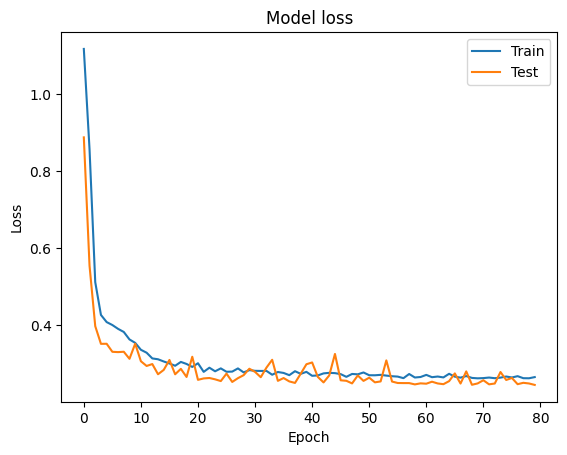

4/4 [==============================] - 0s 3ms/step


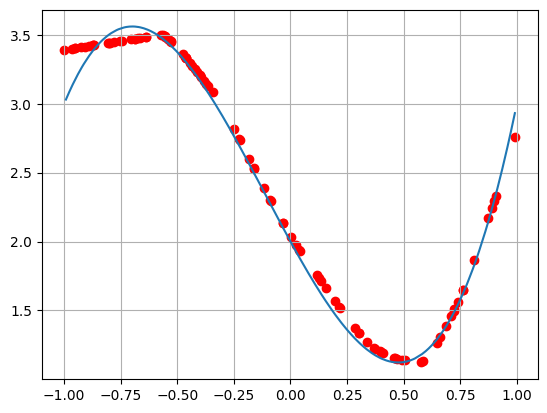

In [25]:
score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)


import matplotlib.pyplot as plt
# print performance
print()
print('Test loss:', score[0]) #la funzione costo ovvero mse
print('Test accuracy:', score[1]) #
print("sigma:", sigma)
print("N_train:", x_train.size)



# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

4/4 [==============================] - 0s 2ms/step


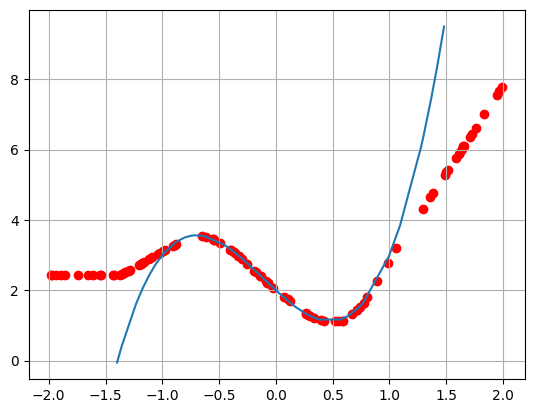

In [42]:
x_predicted = np.random.uniform(-2, 2, 100)
x_valid=np.random.uniform(-1.5,1.5,50)
x_valid.sort()
y_target = function(a,b,c,d,x_valid)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r')
plt.plot(x_valid, y_target)
plt.grid(True)
plt.show()

## <span style="color:blue"> Svolgimento esercizio 11.3 </span>

La rete proposta utilizza 10000 dati di train e 1000 per il test, con un rumore $\sigma=0.1$ e utilizzando 80 epoche. Essa è strutturata in tre layers, rispettivamente composti da 32, 16, 7 neuroni densi con funzione di attivazione relu. Anche questa volta si è utilizzato il sgm come ottimizzatore e la MSE come funzione di costo e metrica. 

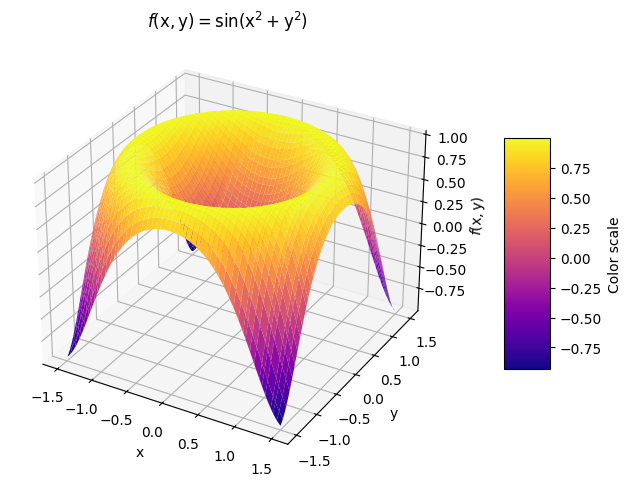

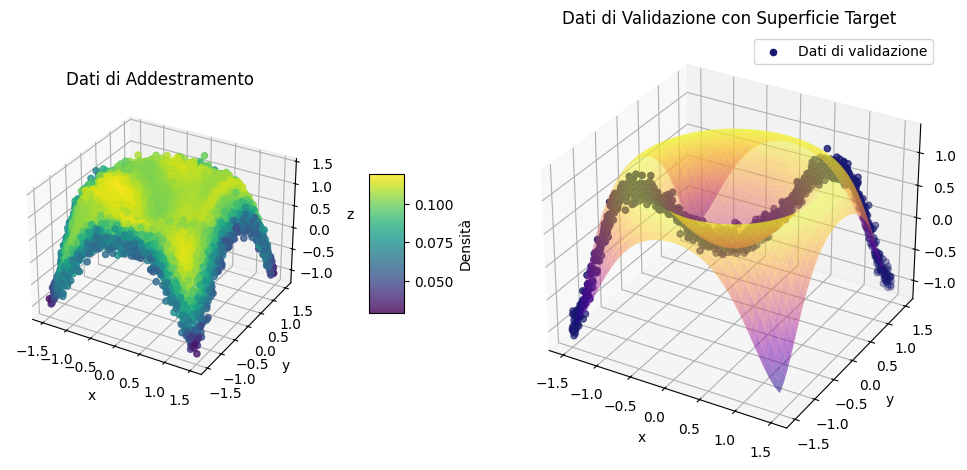

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.stats import gaussian_kde

# Generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-3/2, 3/2, 10000)
y_train = np.random.uniform(-3/2, 3/2, 10000)

x_valid = np.random.uniform(-3/2, 3/2, 1000)
x_valid.sort()

y_valid = np.random.uniform(-3/2, 3/2, 1000)
y_valid.sort()

z_target = np.sin(x_valid**2 + y_valid**2)

sigma = 0.1  # Noise standard deviation
z_train = np.random.normal(np.sin(x_train**2 + y_train**2), sigma)  # Actual measures from which we want to guess regression parameters
z_valid = np.random.normal(np.sin(x_valid**2 + y_valid**2), sigma)

# Plot validation and target dataset
fig = plt.figure(figsize=(7.5, 7.5))
ax = plt.axes(projection='3d')
x, y = np.meshgrid(x_valid, y_valid)
z = np.sin(x**2 + y**2)

# Plot the function surface
surf = ax.plot_surface(x, y, z, cmap='plasma')

# Customize the plot
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$f(\\mathrm{x}, \\mathrm{y})$')
ax.set_title('$f(\\mathrm{x}, \\mathrm{y}) = \\sin(\\mathrm{x}^2 + \\mathrm{y}^2)$')

# Add color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.4, aspect=5, pad=0.1)
cbar.set_label('Color scale')

# Show the plot
plt.show()

# Calculate density for training data
xy_train = np.vstack([x_train, y_train])
density_train = gaussian_kde(xy_train)(xy_train)

# Plot generated data along with the target function surface
fig = plt.figure(figsize=(12, 6))

# Plot of training data
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(x_train, y_train, z_train, c=density_train, cmap='viridis', marker='o', label='Dati di addestramento', alpha=0.8)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Dati di Addestramento')
cbar1 = fig.colorbar(sc1, ax=ax1, shrink=0.3, aspect=4, pad=0.14)
cbar1.set_label('Densità')

# Plot of validation data
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x_valid, y_valid, z_valid, c='midnightblue', marker='o', label='Dati di validazione')
ax2.plot_surface(x, y, z, cmap='plasma', alpha=0.5)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('Dati di Validazione con Superficie Target')
ax2.legend()

# Show the plot
plt.show()

In [57]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(32, input_shape=(2,),activation="relu"))
model.add(Dense(16, input_shape=(1,),activation="relu"))
model.add(Dense(7, input_shape=(1,),activation="relu"))
model.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

# get a summary of our composed model
model.summary()

history = model.fit(x=np.column_stack((x_train, y_train)),
                    y=z_train,
                    batch_size=32,
                    epochs=80,
                    shuffle=True,
                    validation_data=(np.column_stack((x_valid, y_valid)), z_valid))

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 32)                96        
                                                                 
 dense_56 (Dense)            (None, 16)                528       
                                                                 
 dense_57 (Dense)            (None, 7)                 119       
                                                                 
 dense_58 (Dense)            (None, 1)                 8         
                                                                 
Total params: 751 (2.93 KB)
Trainable params: 751 (2.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/80
313/313 [==============================] - 2s 6ms/step - loss: 0.1753 - mse: 0.1753 - val_loss: 0.3438 - val_mse: 0.3438
Epoch 2/80
313/313 [===

32/32 [==============================] - 0s 3ms/step - loss: 0.0112 - mse: 0.0112

Test loss: 0.011233462020754814
Test accuracy: 0.011233462020754814
sigma: 0.1
N_train: 10000


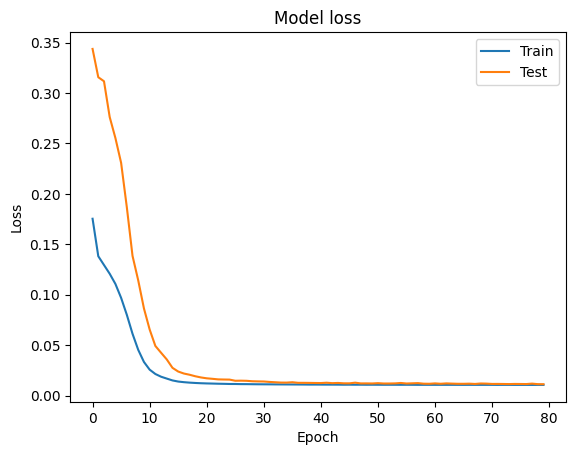

32/32 [==============================] - 0s 2ms/step


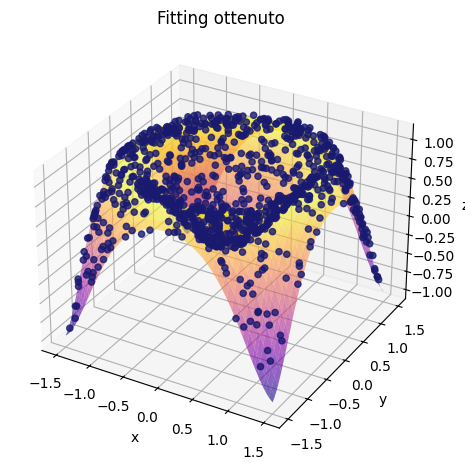

In [64]:
# Valutazione del modello sui dati di validazione
score = model.evaluate(np.column_stack((x_valid, y_valid)), z_valid, batch_size=32, verbose=1)

# Stampa delle metriche di performance
print()
print('Test loss:', score[0])  # La funzione costo, ovvero MSE
print('Test accuracy:', score[1])  # Non applicabile in un problema di regressione
print("sigma:", sigma)
print("N_train:", x_train.size)

# Plot della loss durante l'addestramento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

# Generazione di dati predetti
x_predicted = np.random.uniform(-3/2, 3/2, 1000)
y_predicted = np.random.uniform(-3/2, 3/2, 1000)
xy_predicted = np.column_stack((x_predicted, y_predicted))
z_predicted = model.predict(xy_predicted)

# Plot dei dati predetti insieme alla superficie target
fig = plt.figure(figsize=(12, 6))

# Plot dei dati predetti
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_predicted, y_predicted, z_predicted, c='midnightblue', marker='o', label='Predicted Data', alpha=0.8)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Dati Predetti')

# Plot della superficie target
ax1.plot_surface(x, y, z, cmap='plasma', alpha=0.6, label='Superficie Target')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Fitting ottenuto')

# Mostra il plot
plt.show()